<a href="https://colab.research.google.com/github/cyber-Olga-2077/UMF/blob/main/Case1Krzyczkowska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Ładuję dane

In [2]:
data_frame = pd.read_csv('case1.csv')

Ogólny przegląd danych - zauważam, że zbiór jest niezbilansowany (ale tylko delikatnie)

In [3]:
data_frame.head()


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [4]:
data_frame['FLAG'].value_counts()

FLAG
0    7662
1    2179
Name: count, dtype: int64

In [5]:
ones = (data_frame['FLAG']==1).sum()
zeros = (data_frame['FLAG']==0).sum()
balance = ones/zeros

print(balance)

0.2843904985643435


Usuwam od razu 2 niepotrzebne kolumny

In [6]:
data_frame.drop("Index", axis='columns', inplace=True)
data_frame.drop("Address", axis='columns', inplace=True)

In [7]:
data_frame.shape

(9841, 48)

Zamieniam 2 ostatnie kolumny przy pomocy LabelEncoder (zamiast stringów mamy wartość int)

In [8]:
le = LabelEncoder()

columns_to_le = data_frame.columns[-2:]

for column in columns_to_le:
    data_frame[column] = le.fit_transform(data_frame[column].astype(str))

print(data_frame[columns_to_le].head())

   ERC20 most sent token type  ERC20_most_rec_token_type
0                          63                        299
1                         154                        257
2                         301                        435
3                         216                        435
4                         237                        154


In [9]:
data_frame.shape

(9841, 48)

Sprawdzam, w których kolumnach  występują NaN i uzupełniam je o średnią. Robię tak, gdyż w etapie usuwania outlierów podczas usuwania wartości powyżej progu usuwane także są wartości NaN, co prowadziło do niechcianego zmiejszenia zbioru jedynek z ok. 2tys do 1341.

In [10]:
print("Before Nan filling")

for column in data_frame:
  if data_frame[column].isnull().any():
    mean_for_column = data_frame[column].mean()
    print(data_frame[column].isna().sum(), mean_for_column)
    data_frame[column].fillna(mean_for_column, inplace = True)

Before Nan filling
829 36.255659121171774
829 129620673.24360897
829 13868492.609468944
829 110.93920668739632
829 5.6380381713271195
829 7.598535286284953
829 0.0034398579671549045
829 4.90190856635597
829 0.0
829 0.0
829 0.0
829 0.0
829 485.61468759065684
829 125252360.1523875
829 4346203.068974394
829 11741.257297339325
829 13035935.151901012
829 6318389.134577394
829 0.0
829 0.0
829 0.0
829 1.3849312028406568
829 4.826675543719485


In [11]:
print("After Nan filling")

for column in data_frame:
  print(data_frame[column].isna().sum(), data_frame[column].mean())

After Nan filling
0 0.22142058733868508
0 5086.878720658469
0 8004.851183822782
0 218333.25765166144
0 115.93171425668123
0 163.700945025912
0 3.729702266029875
0 30.360938928970633
0 25.840158520475562
0 43.84515347850828
0 523.1524805210852
0 100.71172136073568
0 4.800089521898181
0 314.61729701798595
0 44.75573123534193
0 3.04847068387359e-06
0 7.72573925414084e-06
0 5.387054161162484e-06
0 283.3623615486231
0 10160.923338054521
0 11638.31863009278
0 7.725710090437964e-06
0 1477.3952841556463
0 36.255659121171774
0 129620673.24360895
0 13868492.609468943
0 110.93920668739632
0 5.6380381713271195
0 7.598535286284954
0 0.003439857967154904
0 4.901908566355969
0 0.0
0 0.0
0 0.0
0 0.0
0 485.61468759065684
0 125252360.15238748
0 4346203.068974393
0 11741.257297339327
0 13035935.151901014
0 6318389.1345773935
0 0.0
0 0.0
0 0.0
0 1.3849312028406568
0 4.826675543719484
0 110.61904278020526
0 145.89188090641196


Tworzę box ploty, by na ich  podstawie wyznaczyć momenty odcięcia

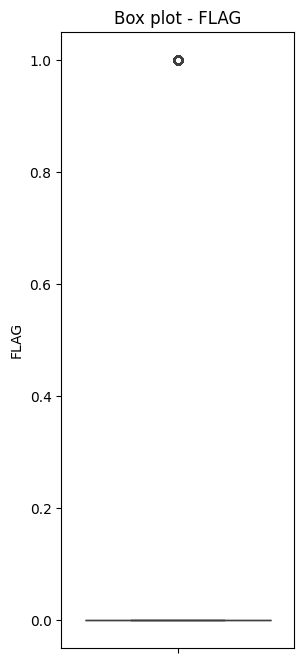

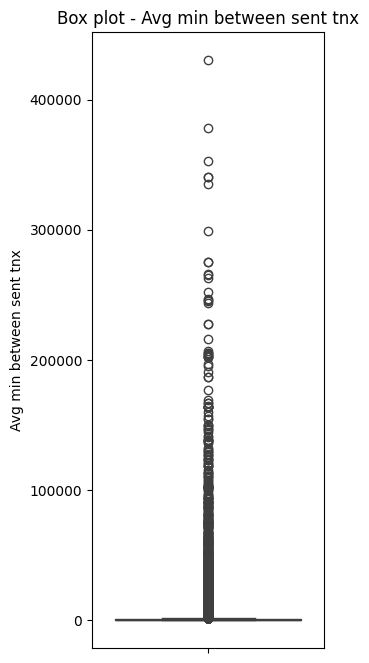

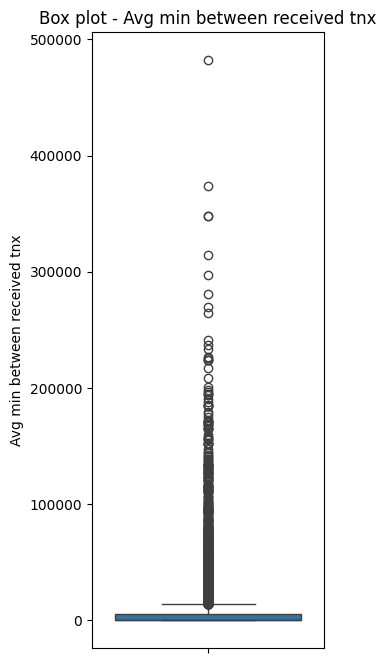

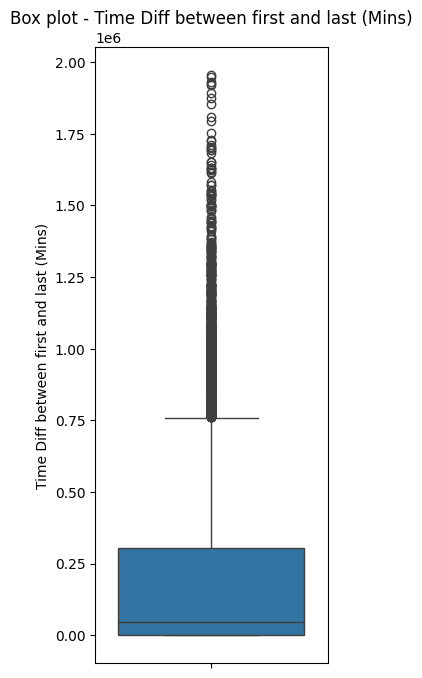

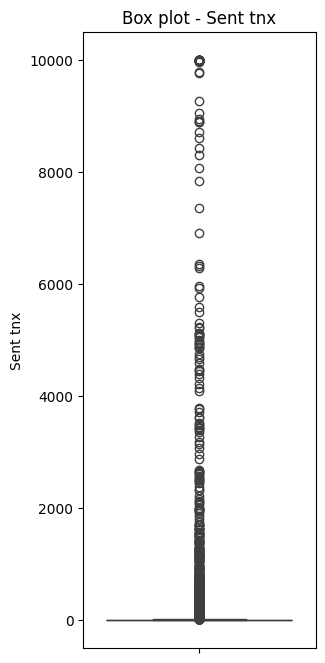

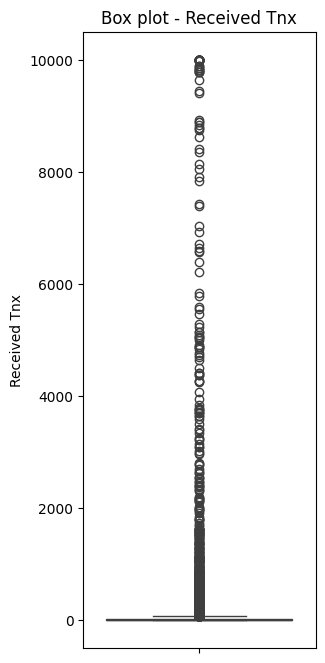

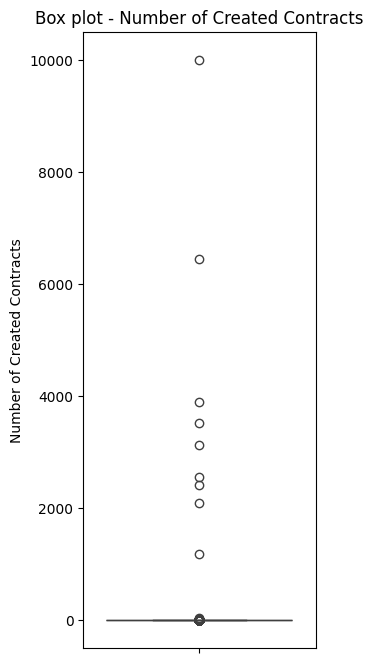

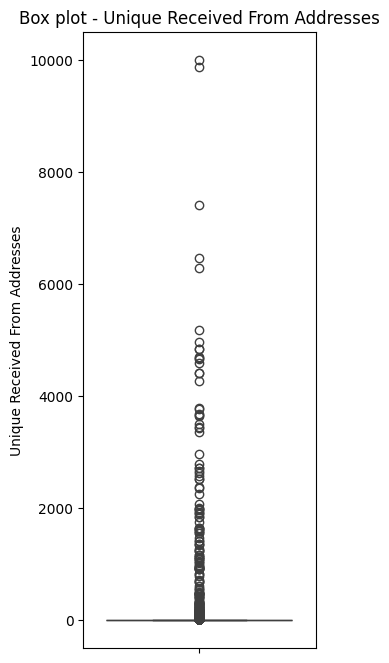

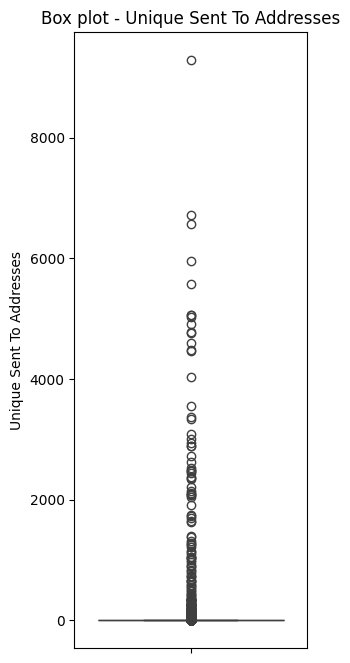

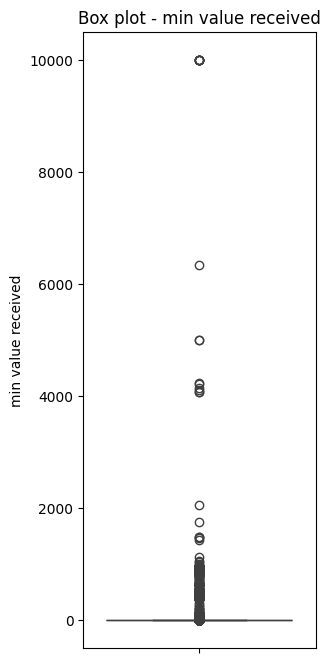

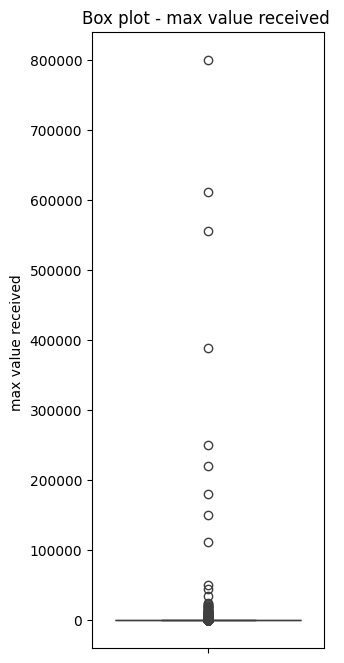

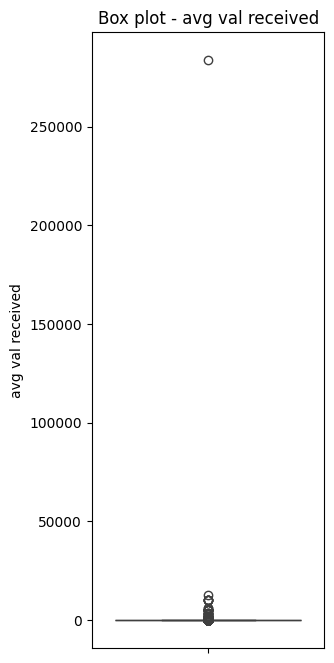

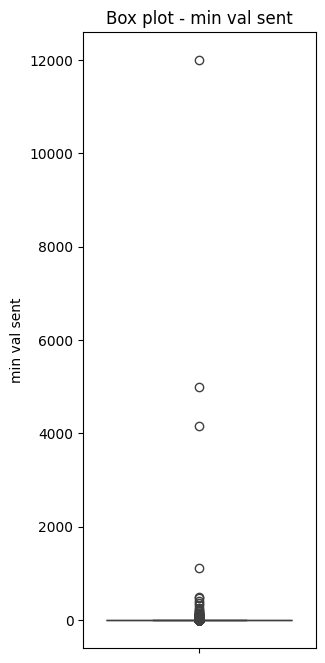

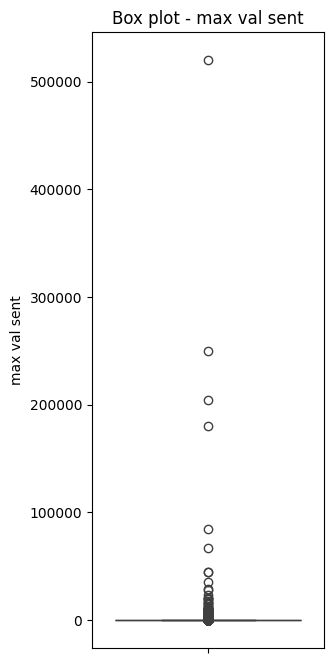

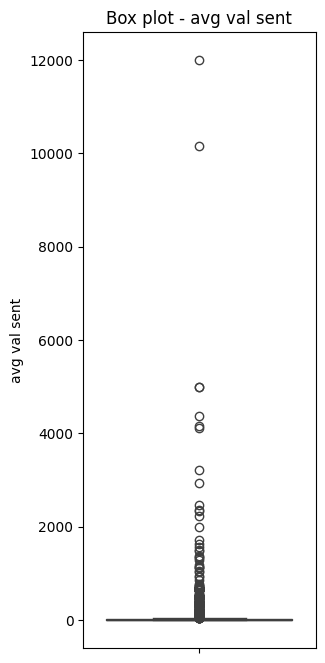

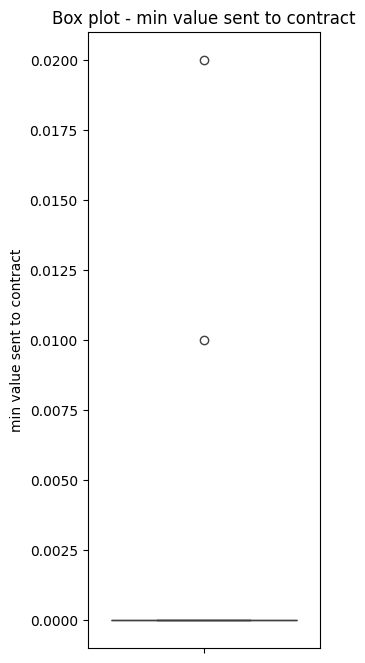

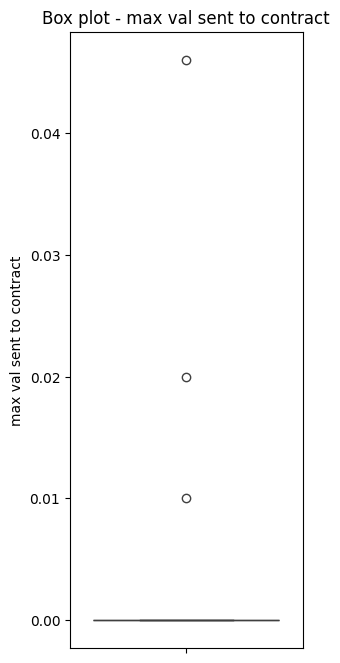

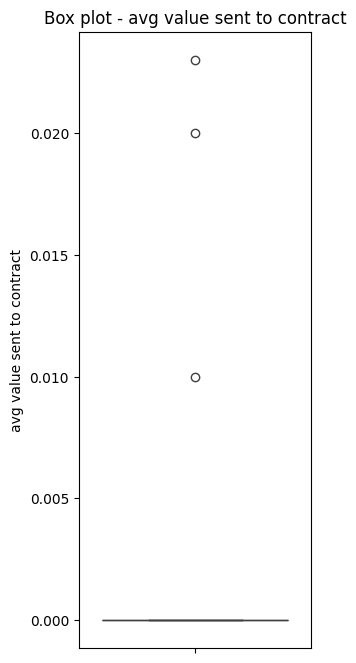

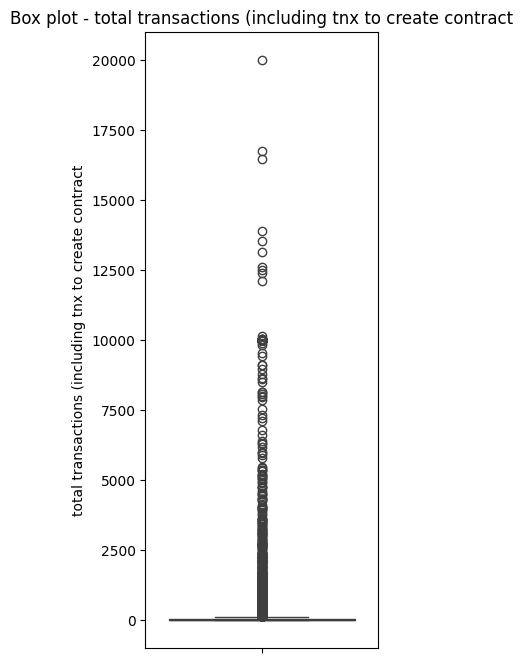

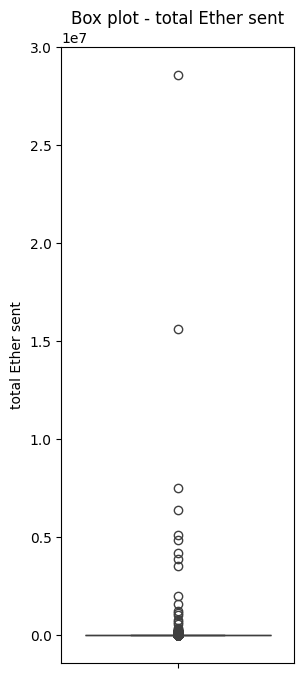

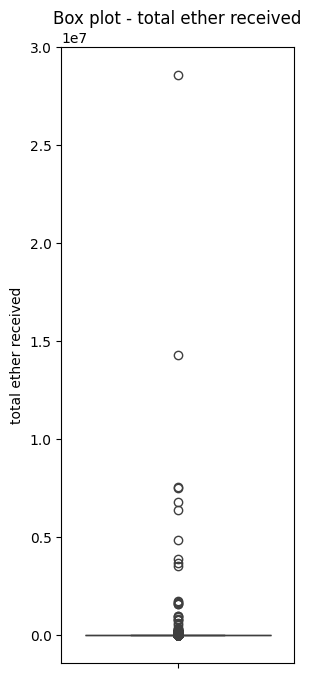

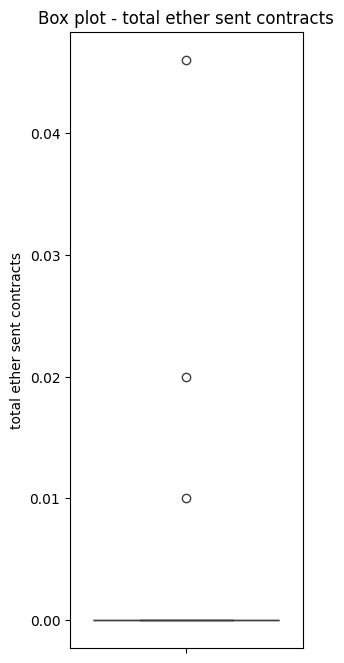

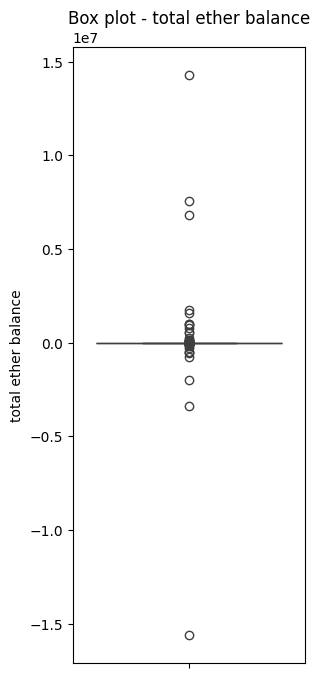

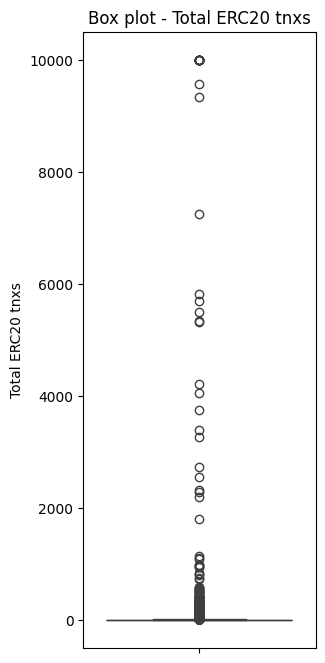

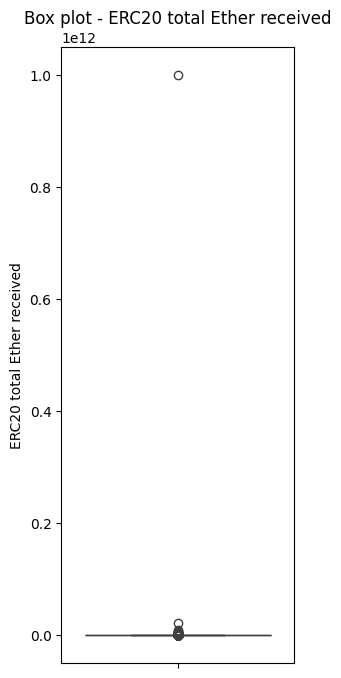

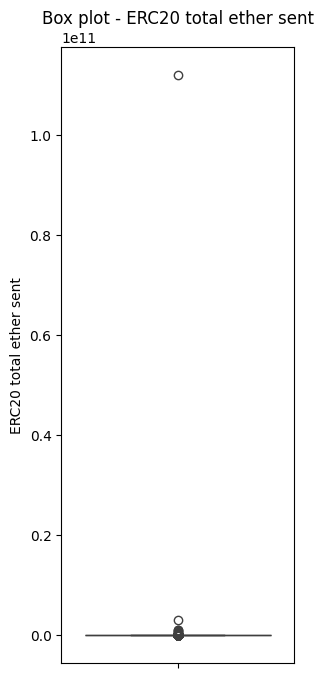

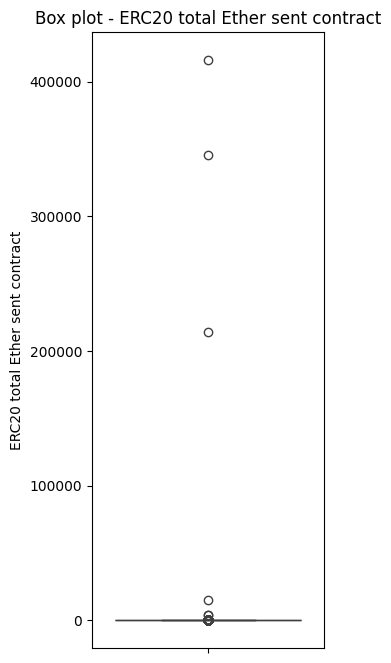

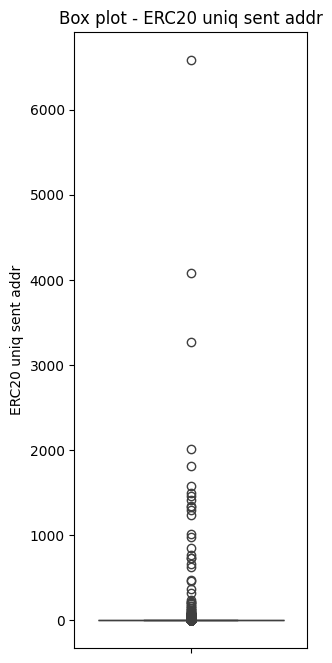

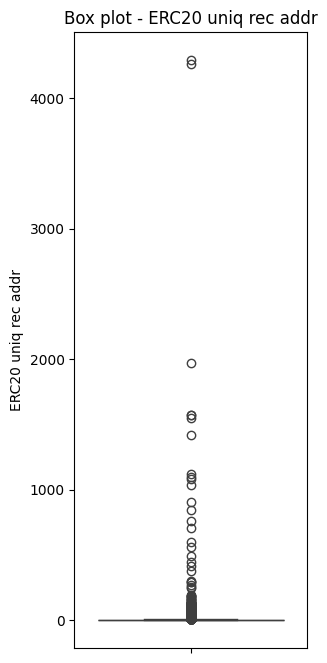

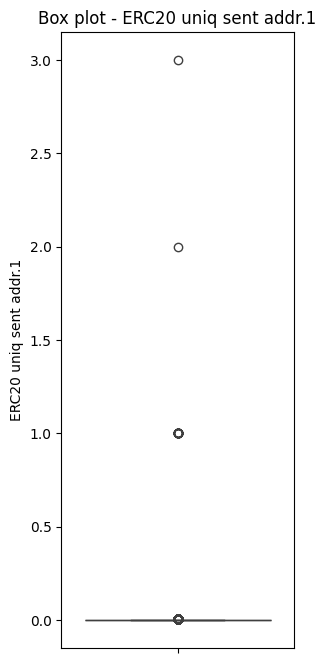

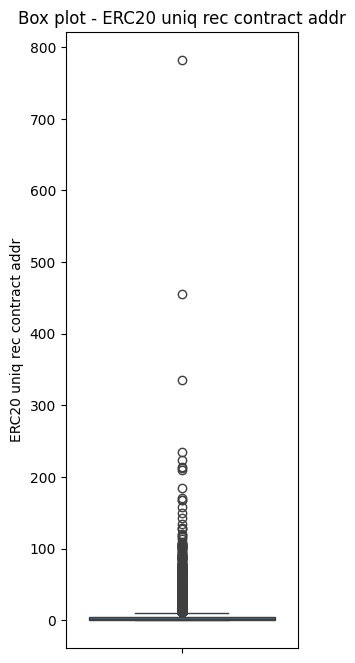

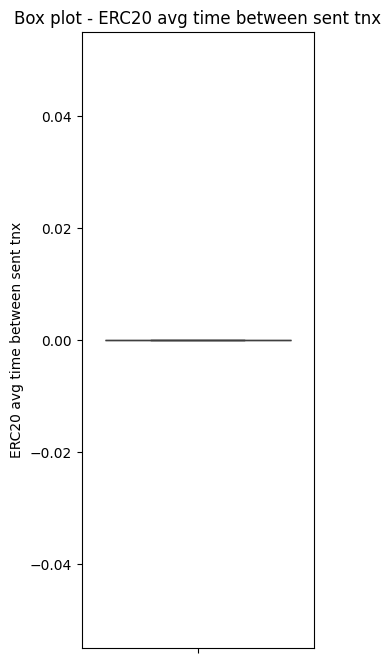

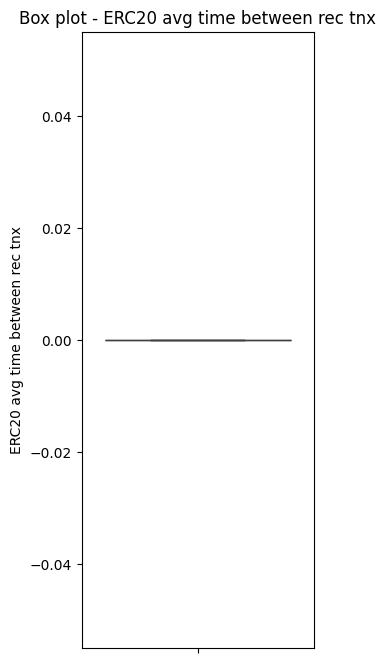

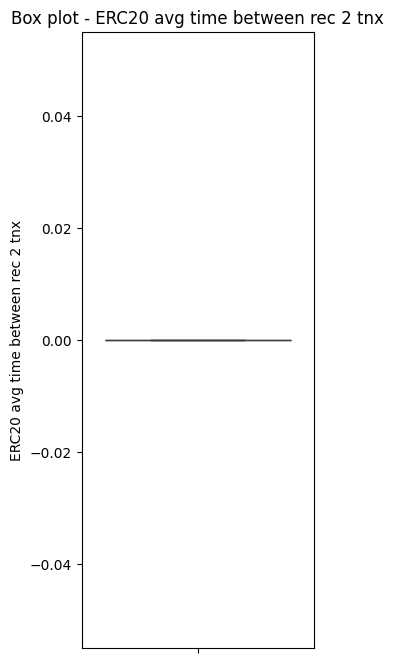

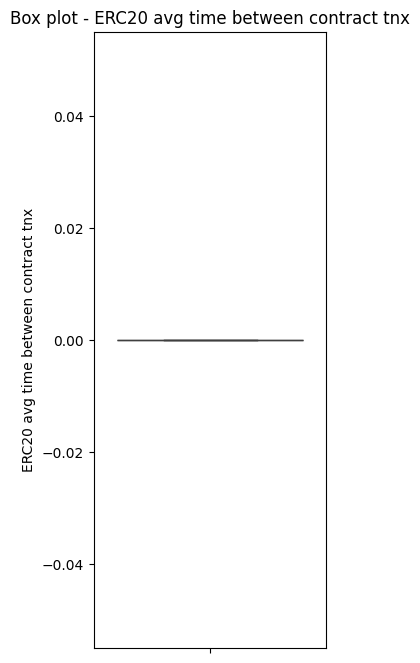

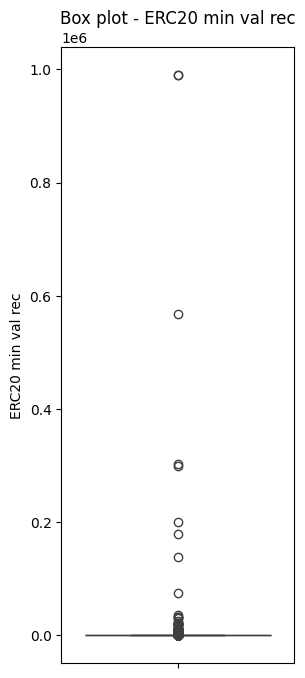

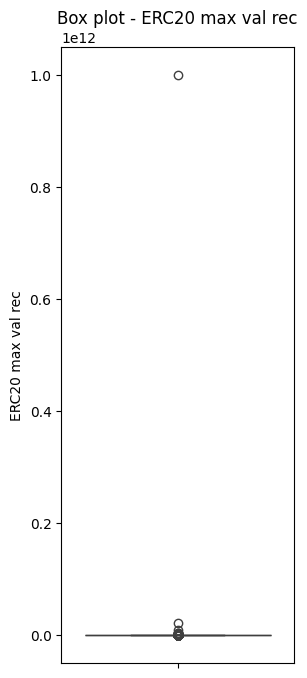

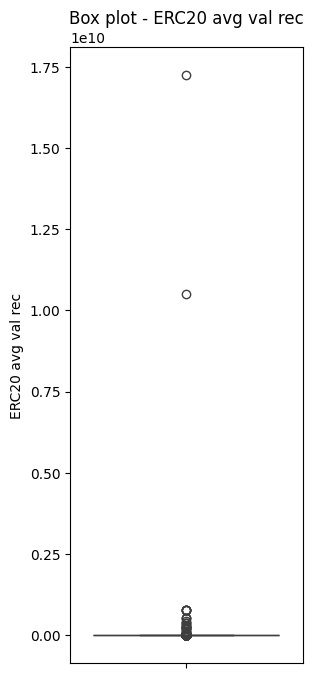

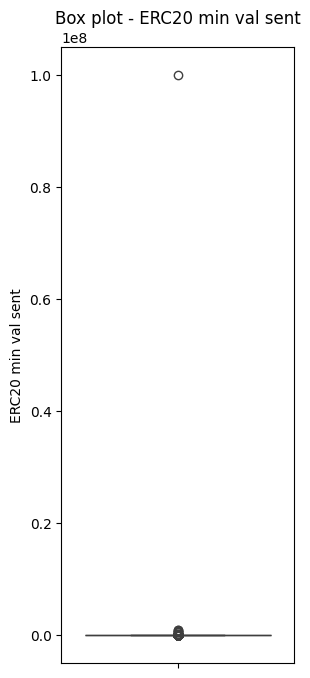

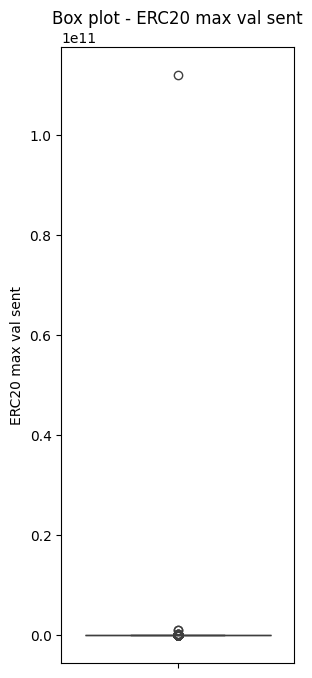

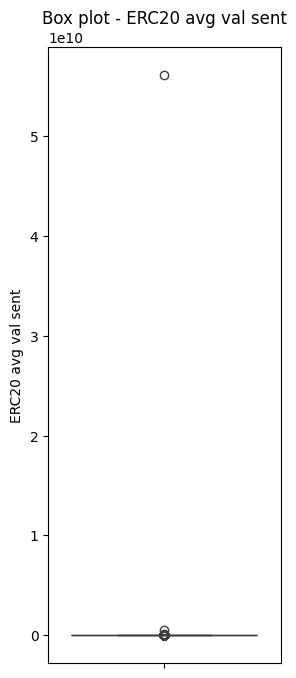

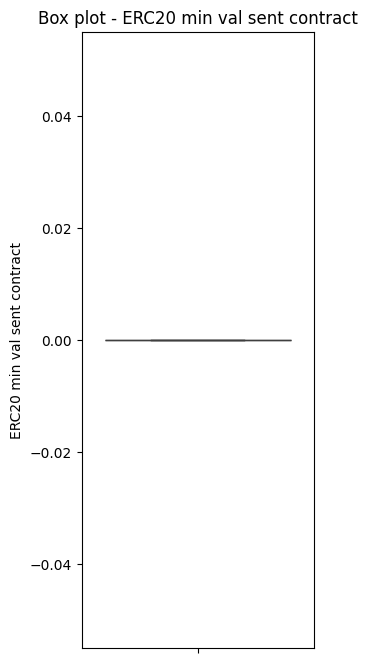

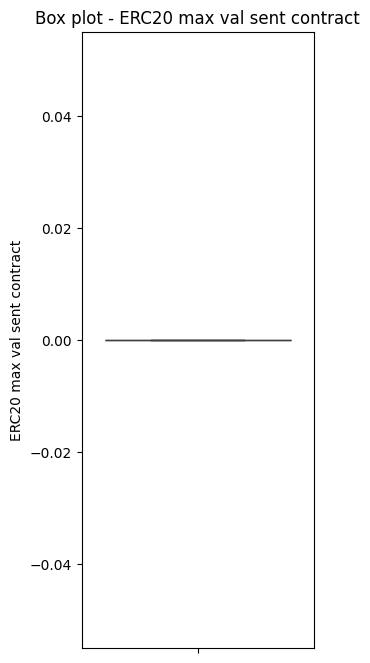

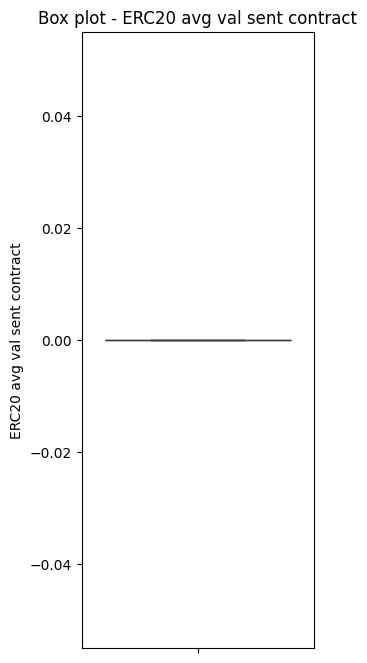

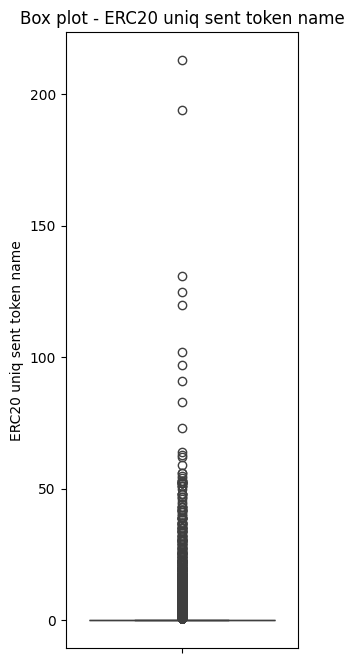

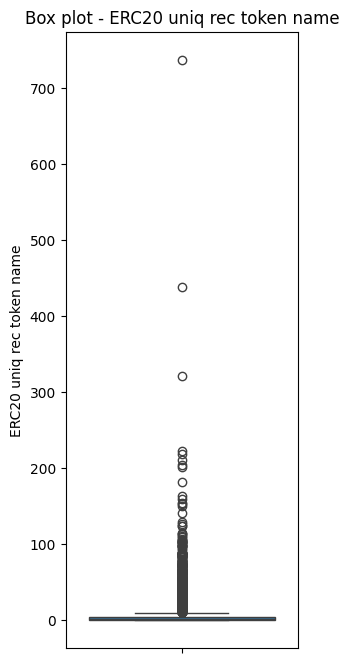

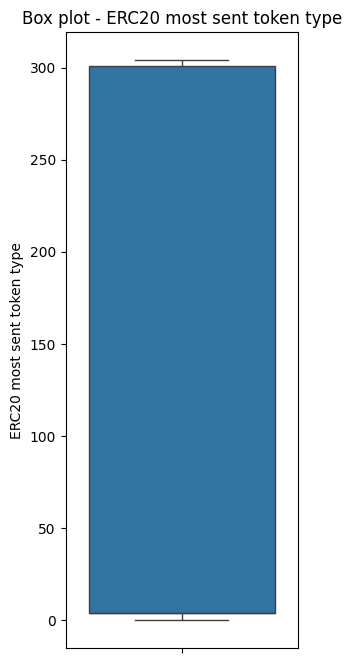

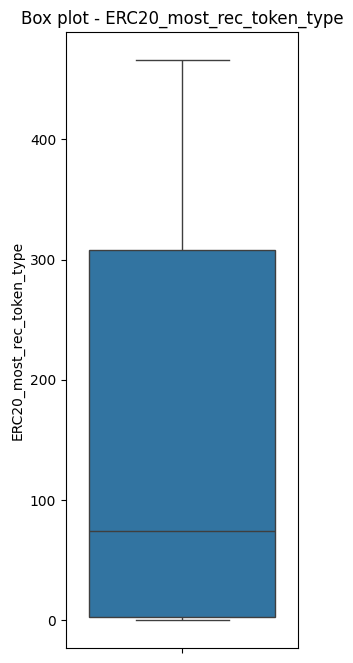

In [12]:
for column in data_frame:
    plt.figure(figsize=(3, 8))
    sns.boxplot(data=data_frame, y=column)
    plt.title(f'Box plot - {column}')
    plt.show()

In [13]:
# printing coolumn names for the next dictionary

print(data_frame.columns)

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance', 'Total ERC20 tnxs',
       'ERC20 total Ether received', 'ERC20 total ether sent',
       'ERC20 total Ether sent contract', 'ERC20 uniq sent addr',
       'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1',
       'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx',
       'ERC20 avg time between rec tnx', 'ERC20 avg time between 

Tworzę słownik

In [14]:
cut_off_points = {
    'Avg min between sent tnx': 250000,
    'Avg min between received tnx': 250000,
    'Time Diff between first and last (Mins)': 1500000,
    'Sent tnx': 3000,         #come back to it
    'Received Tnx': 6000,    #come back
    'Number of Created Contracts': 1.6,
    'Unique Received From Addresses': 1500,
    'Unique Sent To Addresses': 450,
    'min value received': 1300,
    'max value received ': 4000,
    'avg val received': 2000,
    'min val sent': 200,
    'max val sent': 4000,
    'avg val sent': 800,
    'total transactions (including tnx to create contract': 11000,
    'total Ether sent': 50000,
    'total ether received': 50000,
    'total ether sent contracts': 0.01,
    'total ether balance': 30000,
    'Total ERC20 tnxs': 50,
    'ERC20 total Ether received': 100000000000,
    'ERC20 total ether sent': 10000000000,
    'ERC20 total Ether sent contract': 50000,
    'ERC20 uniq sent addr': 15,
    'ERC20 uniq rec addr': 1000,
    'ERC20 uniq sent addr.1': 40,
    'ERC20 uniq rec contract addr': 100,
    'ERC20 avg time between sent tnx': 0.5,
    'ERC20 avg time between rec tnx': 0.05,
    'ERC20 avg time between rec 2 tnx': 0.05,
    'ERC20 avg time between contract tnx': 0.05,
    'ERC20 min val rec': 100000,
    'ERC20 max val rec': 200000000,
    'ERC20 avg val rec': 5000000,
    'ERC20 min val sent': 100000,
    'ERC20 max val sent': 20000000,
    'ERC20 avg val sent': 6400000,
    'ERC20 uniq sent token name': 10,
    'ERC20 uniq rec token name': 12,
}


Usuwanie outlierów zajęło kilka prób: po każdej iteracji pętli for wypisuję, ile wierszów zostało uciętych oraz jak wyglądają wielkości zbiorów zmiennej y (FLAGA 1 lub 0).

Celem jest usunięcie tych outlierów po konkretnych wartościach (cut_off_points) przy jednoczesnym pozostawieniu w miarę dużej liczby wierszy i, co najważniejsze, pozostawieniu jak największej próbki flagi 1 (przestępstwo), która jest mniejsza w tym niezbilansowanym zbiorze.

Prowadzi to oczywiście do sytuacji, w których czasem nie usuwam z kolumny praktycznie żadnych outlierów, bo choć wydawaćby się mogło, że zostawiam niepotrzebne dane odstające, to odcięcie ich na wysokim poziomie (czyli prawie najwyższa wartość) spowodowałoby zmniejszenie się zbioru jedynek o około nawet 1/3 lub 1/2 (a tego nie chcemy). Zakładam więc, że te "dziwne wartości" mają duży wpływ na to, czy coś jest klasyfikowane jako przestępstwo.

W ostateczności około 15% danych zostaje usuniętych.

In [15]:
#usuwanie outlierów

for column, cut_off in cut_off_points.items():
  print(data_frame.shape, column, cut_off)
  print(data_frame['FLAG'].value_counts())
  data_frame = data_frame[data_frame[column] <= cut_off]
  print()

data_frame = data_frame[(data_frame['total ether balance'] >= -0.2)]

(9841, 48) Avg min between sent tnx 250000
FLAG
0    7662
1    2179
Name: count, dtype: int64

(9828, 48) Avg min between received tnx 250000
FLAG
0    7650
1    2178
Name: count, dtype: int64

(9819, 48) Time Diff between first and last (Mins) 1500000
FLAG
0    7641
1    2178
Name: count, dtype: int64

(9777, 48) Sent tnx 3000
FLAG
0    7599
1    2178
Name: count, dtype: int64

(9680, 48) Received Tnx 6000
FLAG
0    7502
1    2178
Name: count, dtype: int64

(9605, 48) Number of Created Contracts 1.6
FLAG
0    7428
1    2177
Name: count, dtype: int64

(9583, 48) Unique Received From Addresses 1500
FLAG
0    7411
1    2172
Name: count, dtype: int64

(9575, 48) Unique Sent To Addresses 450
FLAG
0    7404
1    2171
Name: count, dtype: int64

(9568, 48) min value received 1300
FLAG
0    7397
1    2171
Name: count, dtype: int64

(9548, 48) max value received  4000
FLAG
0    7384
1    2164
Name: count, dtype: int64

(9530, 48) avg val received 2000
FLAG
0    7368
1    2162
Name: count, dtype

Podział na zmienne wyjaśniające i wyjaśnioną

In [16]:
X = data_frame.drop('FLAG', axis = 1)
y = data_frame['FLAG']

Standaryzacja danych za pomocą funkcji StandardScaler.

In [17]:
scaler = StandardScaler()

for column in X.columns:
  X[column] = scaler.fit_transform(X[[column]])

PCA - najpierw sprawdzam, ile kolumn wyjaśnia jaki procent wariancji

Wybieram 12, gdyż wyjaśniają aż 92% wariancji.

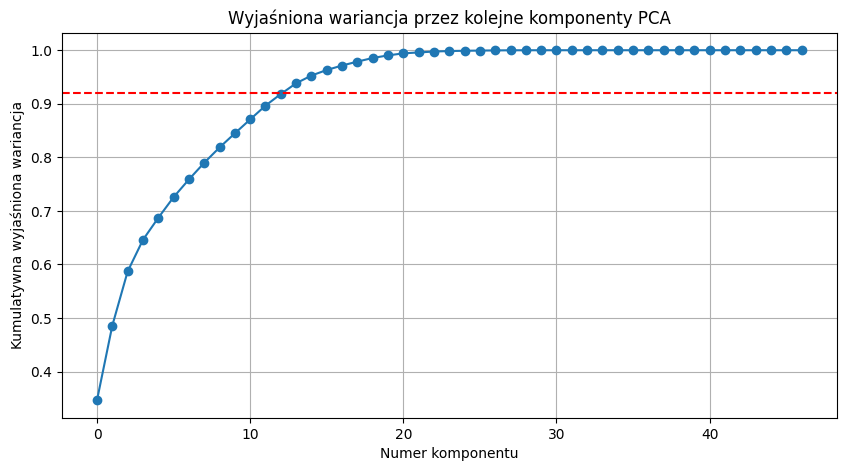

In [18]:
pca = PCA()
pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Numer komponentu')
plt.ylabel('Kumulatywna wyjaśniona wariancja')
plt.title('Wyjaśniona wariancja przez kolejne komponenty PCA')
plt.grid(True)
plt.axhline(y=0.92, color='r', linestyle='--')


plt.show()

In [19]:
pca = PCA(n_components = 12)
X = pca.fit_transform(X)

Tworzę podział na zestawy testowe i treningowe

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.25, random_state = 42, shuffle = True, stratify = y)

**Tworzę modele**

Najpier zwykłe knn

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [22]:
accuracy_score(y_test, knn_y_pred)

0.9845485272815065

In [23]:
recall_score(y_test, knn_y_pred)

0.9596774193548387

Teraz próba undersamplingu przez Near Miss

In [24]:
nm = NearMiss(version = 3, n_neighbors = 3)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [25]:
knn_nm = KNeighborsClassifier(n_neighbors=3)
knn_nm.fit(X_train_nm, y_train_nm)

y_pred_nm = knn_nm.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred_nm)

0.9628198937711251

In [27]:
recall_score(y_test, y_pred_nm)

0.9637096774193549

Następnie knn przy SMOTE (oversampling)

In [28]:
os = SMOTE()
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

In [29]:
knn_os = KNeighborsClassifier(n_neighbors=3)
knn_os.fit(X_train_os, y_train_os)

y_pred_os = knn_os.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred_os)

0.9806856591018831

In [31]:
recall_score(y_test, y_pred_os)

0.9737903225806451

Teraz spróbuję podziałać na koszcie funkcji przez regresję liniową ze zbalansowanymi wagami

In [32]:
lr = LogisticRegression(solver ='lbfgs',class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred_lr)

0.8063737324963786

In [34]:
recall_score(y_test, y_pred_lr)

0.9415322580645161

Zobaczmy, jak maszyna wektorów nośnych sobie poradzi

In [35]:
svm = SVC(kernel = 'rbf', random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred_svm)

0.9719942056977305

In [37]:
recall_score(y_test, y_pred_svm)

0.9536290322580645

Sprawdzam, jak zadziała Random Forest

In [38]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [39]:
accuracy_score(y_test, y_pred_rf)

0.9840656687590535

In [40]:
recall_score(y_test, y_pred_rf)

0.9556451612903226

Próbuję, czy SMOTE może polepszyć wyniki mojego Random Forest

In [41]:
os = SMOTE()
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

In [42]:
rf_os = RandomForestClassifier(random_state = 42)
rf_os.fit(X_train_os, y_train_os)

y_pred_rf_os = rf_os.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred_rf_os)

0.9835828102366007

In [44]:
recall_score(y_test, y_pred_rf_os)

0.9657258064516129

Jest lepiej, sprawdzę, czy undersampling coś jeszcze wniesie - najpierw RUS

In [45]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [46]:
rf_rus = RandomForestClassifier(random_state = 42)
rf_rus.fit(X_train_rus, y_train_rus)

y_pred_rf_rus = rf_rus.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred_rf_rus)

0.9806856591018831

In [48]:
recall_score(y_test, y_pred_rf_rus)

0.969758064516129

A teraz Near Miss

In [49]:
nm = NearMiss(version = 3, n_neighbors = 3)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [50]:
rf_nm = RandomForestClassifier(random_state = 42)
rf_nm.fit(X_train_nm, y_train_nm)

y_pred_rf_nm = rf_nm.predict(X_test)

In [51]:
accuracy_score(y_test, y_pred_rf_nm)

0.9811685176243361

In [52]:
recall_score(y_test, y_pred_rf_nm)

0.967741935483871

W przypadku wykrywania oszustw musimy maksymalizować wynik recall, by uniknąc klasyfikacji prawdziwej 1 na przewidywane 0.

W związku z tym decyduję się na model Random Forest przy jednoczesnym użyciu undersamplingu RUS, gdyż daje on wynik ok.  96%.